# **Political Polarization**
---

### **Introduction**
---

With the rise of social media and the increase of information on the internet, over the last few decades, the gap between America's two main political parties, Democrats and Republicans, has grown wider. There have been many good studies that have researched the trend of the growing polarization between the two parties and the ever shrinking middle ground. For this project I wanted to look at twitter data from two prominent congressmen from each party. With politics at it's most divided, I expect it to be relatively easy to find differences in the language used by each party. The two congressmen I will be using is Alexandria Ocasio-Cortez, a democrat representing New York's 14th congressional district. The other is Senator Ted Cruz from Texas who is a republican. The goal of this project is to see if I can build a model that can accurately predict which congressmen tweeted what. Politics can be a stressful topic for some, especially after this year, so the tone of this project is meant to be fun and light-hearted.

### **Data**
---

After searching on the web for the best way to scrape twitter accounts, I found tool that could scrape twitter data through the command line. With a bit more searching I found a python wrapper library for that tool. I created my own function using this library to fine tune the tool and get exactly what I wanted. The data is from the twitter accounts 'AOC' and 'SenTedCruz' consisting of all their tweets from January 1, 2020 - December 1, 2020. Below are the links to the sources that helped me gather the data  
*Sources*   
https://github.com/MartinBeckUT/TwitterScraper/blob/master/snscrape/python-wrapper/snscrape-python-wrapper.ipynb  
https://medium.com/better-programming/how-to-scrape-tweets-with-snscrape-90124ed006af

In [3]:
# Run the pip install command below to install the library
# !pip install git+https://github.com/JustAnotherArchivist/snscrape.git

In [4]:
import pandas as pd
import numpy as np
import re
import snscrape.modules.twitter as sntwitter
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.style as style

In [5]:
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

In [6]:
def scrape_twitter_account(account, start_date, end_date, num_tweets):
    temp_str = 'from:' + account + ' since:' + start_date + ' until:' + end_date
    temp_list = []
    for i, tweet in enumerate(sntwitter.TwitterSearchScraper(temp_str).get_items()):
        if i > num_tweets:
            break
        temp_list.append([tweet.date, tweet.id, tweet.content, tweet.user.username])
    return temp_list

In [7]:
#setting the number of tweets I want to return
n_tweets = 3000

#setting what twitter accounts I want to scrape
twitter_accounts = ['AOC', 'SenTedCruz']

#setting time period of tweets to get an accurate comparison
start_date = '2020-01-01'
end_date = '2020-12-01'

aoc_tweets = scrape_twitter_account(twitter_accounts[0], start_date, end_date, n_tweets)
cruz_tweets = scrape_twitter_account(twitter_accounts[1], start_date, end_date, n_tweets)

Once I collected the data, the next step was to clean the tweets. One of the first things I had to do was to remove twitter username handles from the tweets. I created my own function to do this that worked, but I found a package from the nltk library that could strip twitter usernames for me. (Lucky me!) I also made all the text lower case and cleaned it of non-alphanumeric characters. Finally I applied a Term Frequency Inverse Document Frequency vectorizer (TF-IDF) to preprocess the text and get it ready to use for machine learning algorithms.

In [8]:
# Creating a dataframe from the tweets list above
aoc_df = pd.DataFrame(aoc_tweets, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])
cruz_df = pd.DataFrame(cruz_tweets, columns=['Datetime', 'Tweet Id', 'Text', 'Username'])

aoc_df.head()
cruz_df.head()

                   Datetime             Tweet Id  \
0 2020-11-28 17:31:42+00:00  1332738952504238085   
1 2020-11-28 05:55:54+00:00  1332563850743386114   
2 2020-11-28 05:44:28+00:00  1332560973933277184   
3 2020-11-28 03:21:40+00:00  1332525034632515585   
4 2020-11-28 03:20:52+00:00  1332524836518813697   

                                                Text Username  
0  Grateful to all who joined us last night!\n\nW...      AOC  
1  We did it!\n\n$200k raised in one livestream (...      AOC  
2                                                 :)      AOC  
3    @Corpse_Husband DM if you need his contact info      AOC  
4     @Corpse_Husband Hasan says he can’t reach you!      AOC  
                   Datetime             Tweet Id  \
0 2020-11-30 19:54:15+00:00  1333499602469867522   
1 2020-11-30 18:03:48+00:00  1333471807333158915   
2 2020-11-30 17:01:41+00:00  1333456176982466562   
3 2020-11-30 16:12:04+00:00  1333443690761756673   
4 2020-11-30 15:14:22+00:00  13334291711676

In [9]:
#Creating a month category for data visualization
aoc_df['Month'] = aoc_df['Datetime'].dt.month
cruz_df['Month'] = cruz_df['Datetime'].dt.month

In [10]:
#Saving the dataframes as csv so I dont have to scrape everytime
# aoc_df.to_csv(r"C:\Users\cherndon\python_practice\Final Project\aoc tweets.csv", index=False)
# cruz_df.to_csv(r"C:\Users\cherndon\python_practice\Final Project\cruz tweets.csv", index=False)

In [11]:
# aoc_df = pd.read_csv(r"C:\Users\cherndon\python_practice\Final Project\aoc tweets.csv",)
# cruz_df = pd.read_csv(r"C:\Users\cherndon\python_practice\Final Project\cruz tweets.csv")

---

### **Exploratory Data Analysis**

In [12]:
print("AOC's average number of tweets per month was {0:.0f}".format(aoc_df.groupby('Month')['Tweet Id'].count().mean()))
print("Ted Cruz'z average number of tweets per month was {0:.0f}".format(cruz_df.groupby('Month')['Tweet Id'].count().mean()))

AOC's average number of tweets per month was 119
Ted Cruz'z average number of tweets per month was 237


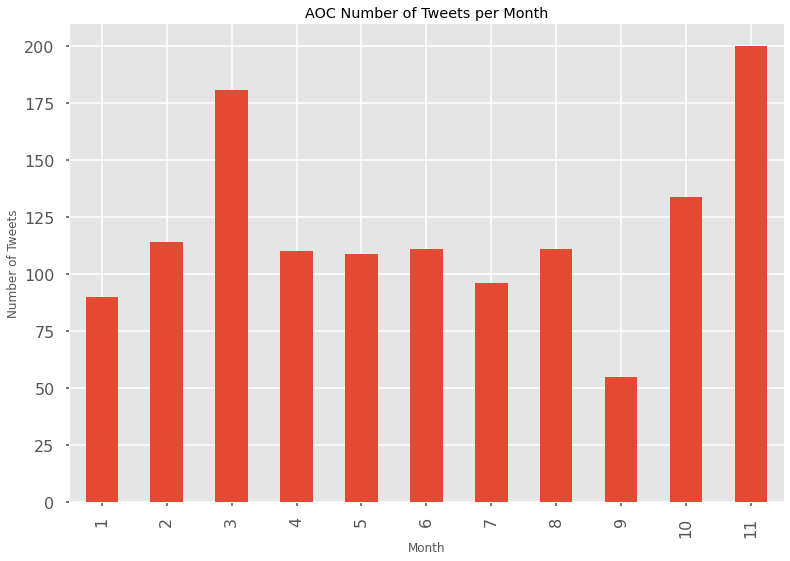

<Figure size 504x504 with 0 Axes>

In [13]:
aoc_df.groupby('Month')['Tweet Id'].count().plot.bar()
plt.ylabel('Number of Tweets')
plt.title("AOC Number of Tweets per Month")
plt.figure(figsize=[7,7]);

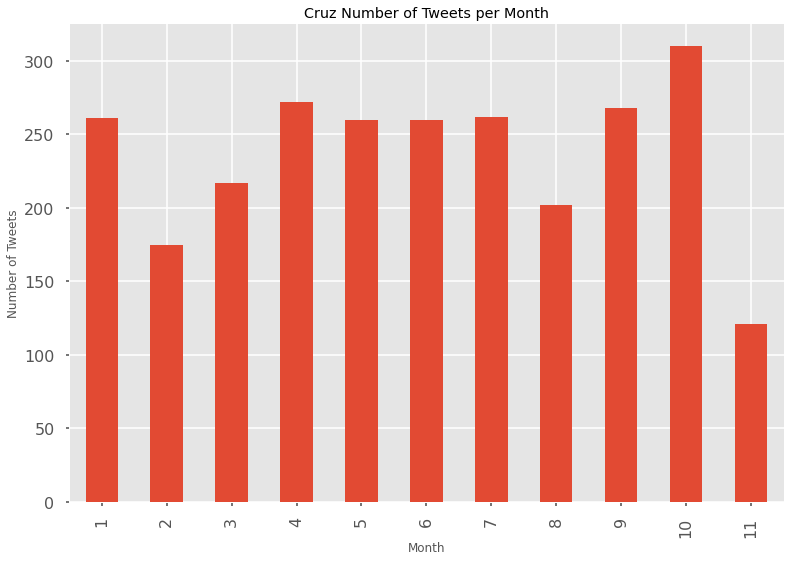

In [14]:
cruz_df.groupby('Month')['Tweet Id'].count().plot.bar()
plt.ylabel('Number of Tweets')
plt.title("Cruz Number of Tweets per Month");

In [15]:
from nltk import wordpunct_tokenize, word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
from collections import Counter

In [16]:
sw = stopwords.words('english')
wn = WordNetLemmatizer()
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

In [17]:
def clean_tweets(x):
    x = x.lower()
    tokens = tknzr.tokenize(x)
    tokens = [tok for tok in tokens if tok.isalnum()]
    tokens = [tok for tok in tokens if tok not in sw]
    tokens = [wn.lemmatize(tok) for tok in tokens]
    return(" ".join(tokens))

In [18]:
aoc_text_clean = aoc_df['Text'].apply(clean_tweets)
cruz_text_clean = cruz_df['Text'].apply(clean_tweets)

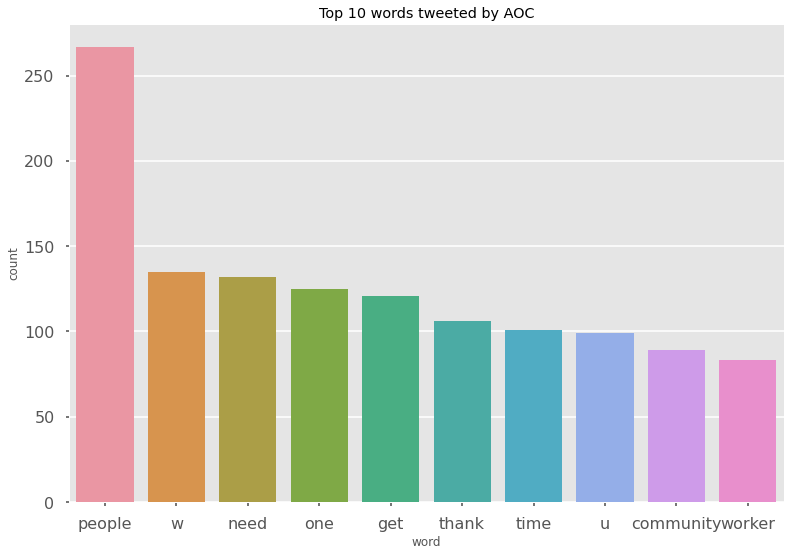

<Figure size 504x504 with 0 Axes>

In [19]:
aoc_top_words = pd.DataFrame(Counter(" ".join(aoc_text_clean).split()).most_common(10))
aoc_top_words.columns = ['word', 'count']

sns.barplot(data=aoc_top_words, x='word', y='count')
plt.title('Top 10 words tweeted by AOC')
plt.figure(figsize=[7,7]);

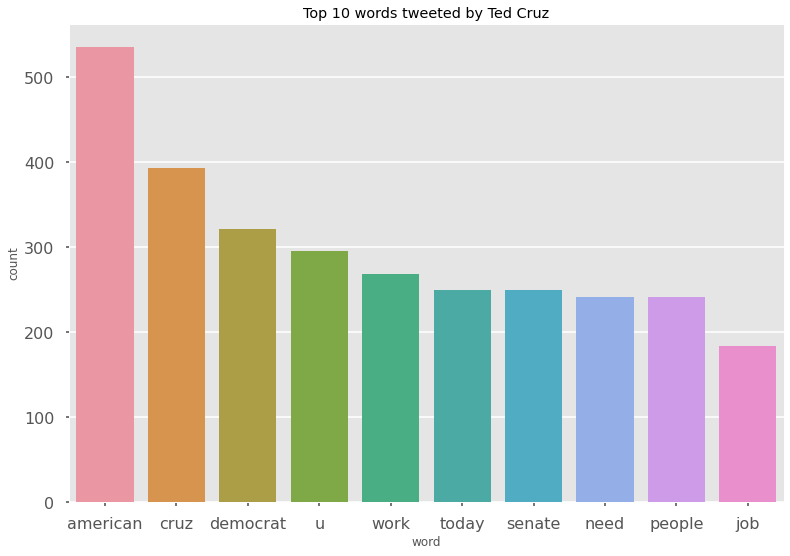

<Figure size 504x504 with 0 Axes>

In [20]:
cruz_top_words = pd.DataFrame(Counter(" ".join(cruz_text_clean).split()).most_common(10))
cruz_top_words.columns = ['word', 'count']

sns.barplot(data=cruz_top_words, x='word', y='count')
plt.title('Top 10 words tweeted by Ted Cruz')
plt.figure(figsize=[7,7]);

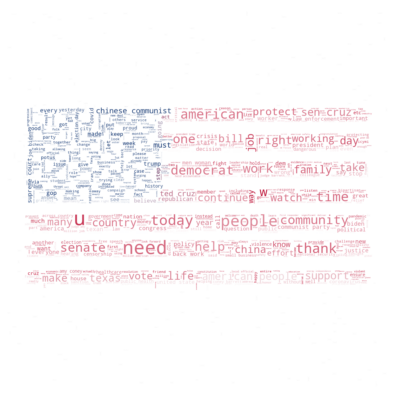

In [21]:
#This visual is useless for providing information for our EDA but it is a fun visual!
#Uncomment the command below if wordcloud is not installed
# !pip install wordcloud
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

all_tweets = pd.concat([aoc_text_clean, cruz_text_clean])
# Counter(' '.join(all_tweets).split()).most_common(10)

#Some rows have empty strings so I must remove them
all_tweets.replace('', np.nan, inplace=True)
all_tweets.dropna(inplace=True)

mask = np.array(Image.open("C:/Users/cherndon/python_practice/Final Project/us flag.jpg"))

wordcloud = WordCloud(background_color="white", max_words=1000, mode="RGBA", mask=mask).generate(' '.join(all_tweets))
# create coloring from image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[7,7])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis('off')
plt.show()

---
The sections below don't really help with EDA or with our predictions. I wanted to run a KMeans clustering on the tweets to see if any interesting grouping would occur in the tweets. Below are the results of the KMeans clustering algorithm 

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
tf = TfidfVectorizer(max_df=.995, min_df=.005)

In [23]:
X = tf.fit_transform(all_tweets)

In [24]:
wcss_tweets = []
for k in range(3, 15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    wcss_tweets.append(kmeans.inertia_)

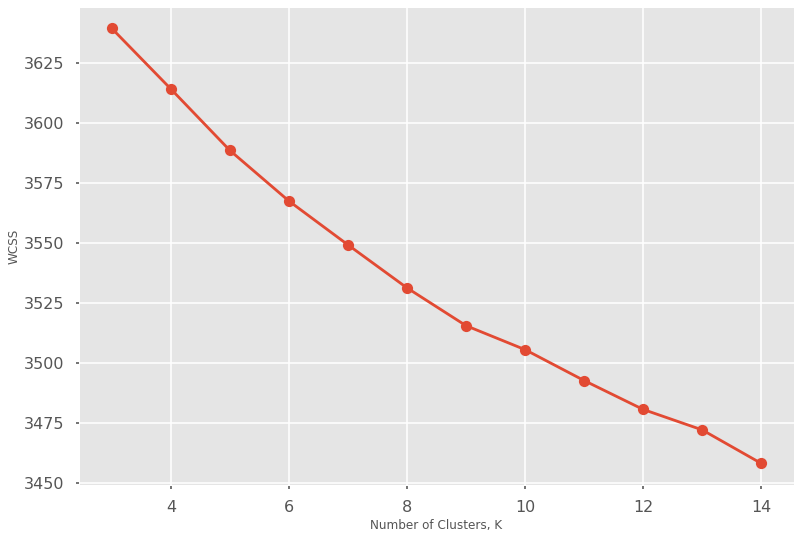

In [25]:
plt.plot(np.arange(3,15), wcss_tweets, marker="o")
plt.xlabel('Number of Clusters, K')
plt.ylabel('WCSS');

In [26]:
from sklearn.cluster import MiniBatchKMeans

In [27]:
k = 8
kmeans = MiniBatchKMeans(k)
kmeans.fit(X)
labs = kmeans.predict(X)

Again this part doesn't provide information that helps us in our prediction process. I wanted to run a clustering method just out of my own curiosity and because the results always surprise me

In [28]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tf.get_feature_names()
for i in range(k):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: thank woman life men space together texan one work way
Cluster 1: work get back help american economy texan safely need together
Cluster 2: people today energy party need american state time like chinese
Cluster 3: cruz sen ted release censorship china bill twitter coronavirus via
Cluster 4: senate vote confirm election people american president republican day promise
Cluster 5: administration iran sanction obama trump fbi doj target snapback admin
Cluster 6: family community need law right officer police enforcement prayer life
Cluster 7: democrat court barrett supreme judge coney amy american watch confirmation


---
### **Methods & Results**

To answer the prediction question, I decided to use a Multinomial Naive Bayes model and Logistic Regression model. I chose Multinomial Naive Bayes because it is easy to use and works great with text classification and Logistic Regression because it is fast and easy to interpret. The major drawback with Logistic Regression is that it assumes a linear relationship between the dependent and independent variables. The disadvantage of using Naive Bayes is that it assumes all the predictor variables are mutually independent of each other. To find the best tuning parameter for both of these models I used a cross validated grid search and used the results for the models. The metrics I will be using to measure how well these models are at predictions are: Accuracy, Precision, Recall, F1, and Area Under the Receiver Operating Characteristics). (ROC AUC curve for short)  
*Accuracy = Number of correct predictions / Total number of predictions*  
*Precision = True Positives / True Positives + False Positives*  
*Recall = True Positives / True Positives + False Negatives*  
*F1 = 2 (Precision x Recall / Precision + Recall)*  
*ROC Curve is the plotted curve of the true positive rate over the False positive rate. The closer the value is to 1 the better the model*  

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.linear_model import LogisticRegression

In [30]:
combined_df = pd.concat([aoc_df, cruz_df])
combined_df.drop(columns=['Datetime', 'Tweet Id', 'Month'], inplace=True)
combined_df['Text'] = combined_df['Text'].apply(clean_tweets)
#Some rows have empty strings so I must remove them
combined_df['Text'].replace('', np.nan, inplace=True)
combined_df.dropna(inplace=True)

In [31]:
combined_df.head()

,Text,Username
0,grateful joined u last night wonderful learnin...,AOC
1,200k raised one livestream whim eviction defen...,AOC
3,dm need contact info,AOC
4,hasan say reach,AOC
5,today using stream fundraise local food pantry...,AOC


Here I am finding the mean of our training set. This step will be very important in validating the accuracy score of our naive bayes model

In [32]:
value_sums = combined_df['Username'].value_counts().sum()
combined_df['Username'].value_counts() / value_sums

SenTedCruz    0.67524
AOC           0.32476
Name: Username, dtype: float64

In [33]:
train, test = train_test_split(combined_df, test_size=0.3, stratify=combined_df.Username, random_state=777)

In [34]:
y_train = (train['Username'] == 'AOC').astype(int)
y_test = (test['Username'] == 'AOC').astype(int)

In [35]:
tfidf = TfidfVectorizer(max_df = .995, min_df = .005)
tfidf.fit(train['Text'])
X_train = tfidf.transform(train['Text'])
X_test = tfidf.transform(test['Text'])

---
#### **Navie Bayes Model**

In [90]:
from sklearn.model_selection import GridSearchCV

In [91]:
#finding the best tunin parameter for Navie Bayes
params = {'alpha': np.linspace(0.15,0.35,20),
         }
nb_grid = GridSearchCV(MultinomialNB(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
nb_grid.fit(X_train,y_train)

print('Train Accuracy : %.3f'%nb_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f'%nb_grid.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f'%nb_grid.best_score_)
print('Best Parameters : ',nb_grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
Train Accuracy : 0.915
Test Accuracy : 0.855
Best Accuracy Through Grid Search : 0.895
Best Parameters :  {'alpha': 0.25526315789473686}
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [92]:
nb = MultinomialNB(nb_grid.best_params_.get('alpha'))
nb.fit(X_train, y_train)
yhat = nb.predict(X_test)

confusion_matrix(y_test, yhat)

array([[743,  37],
       [131, 244]], dtype=int64)

In [93]:
print("The accuracy score of the Multinomial Navie Bayes model is {:.2f}".format(accuracy_score(y_test, yhat)))
print("The f1 score of the Multinomial Navie Bayes model is {:.2f}".format(f1_score(y_test, yhat)))
print("The precision score of the Multinomial Navie Bayes model is {:.2f}".format(precision_score(y_test, yhat)))
print("The recall score of the Multinomial Navie Bayes model is {:.2f}".format(recall_score(y_test, yhat)))

The accuracy score of the Multinomial Navie Bayes model is 0.85
The f1 score of the Multinomial Navie Bayes model is 0.74
The precision score of the Multinomial Navie Bayes model is 0.87
The recall score of the Multinomial Navie Bayes model is 0.65


In [94]:
probabilities = nb.predict_proba(X_test)
y_prob = nb.predict_proba(X_test)[:,1]

In [95]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

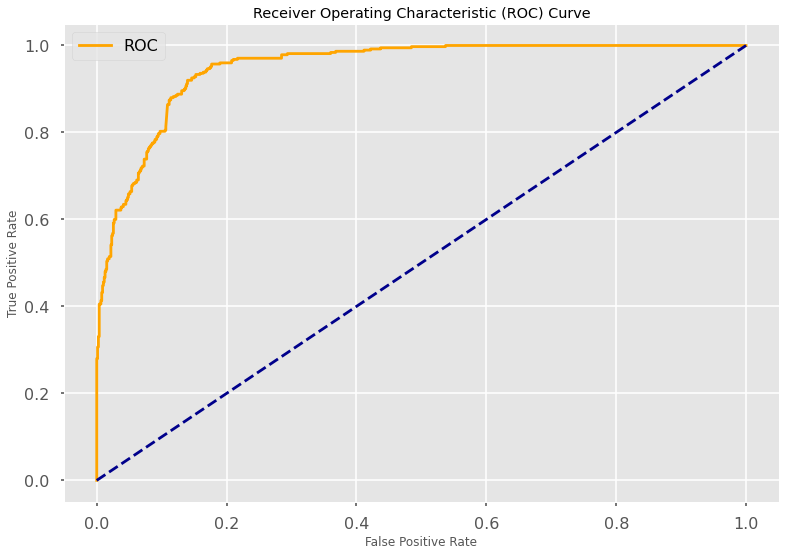

In [96]:
fpr, tpr, thresh = roc_curve(y_test, y_prob)
plot_roc_curve(fpr, tpr)

In [97]:
roc_auc_score(y_test, y_prob)

0.949859829059829

In [98]:
feats = pd.DataFrame()
feats['words'] = tfidf.get_feature_names()
# Convert log probabilities to probabilities. 
feats['AOC'] = np.e**(nb.feature_log_prob_[0, :])
feats['SenTedCruz'] = np.e**(nb.feature_log_prob_[1, :])
feats.set_index('words', inplace=True)

In [99]:
feats.sort_values(by='AOC',ascending=False).head(15)

,AOC,SenTedCruz
words,,
cruz,0.013722,0.000254
american,0.011705,0.001532
democrat,0.008960,0.000498
senate,0.007138,0.001995
sen,0.006958,0.000814
work,0.006587,0.005770
today,0.006284,0.003357
need,0.005430,0.008707
people,0.005153,0.014119


---
#### **Logistic Regression**

In [116]:
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.linspace(2, 3, 100)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(LogisticRegression(), hyperparameters, cv=5, verbose=0)

# Fit grid search
best_model = clf.fit(X_train, y_train)

In [121]:
best_model.best_estimator_.get_params()['C']

2.5858585858585856

In [123]:
lm = LogisticRegression(C=2.5858, penalty='l2')
lm.fit(X_train, y_train)
yhat_log = lm.predict(X_test)

confusion_matrix(y_test, yhat_log)

array([[739,  41],
       [ 79, 296]], dtype=int64)

In [125]:
print("The accuracy score of the Logistic Regression model is {:.2f}".format(accuracy_score(y_test,yhat_log)))
print("The f1 score of the Logistic Regression model is {:.2f}".format(f1_score(y_test,yhat_log)))
print("The precision score of the Logistic Regression model is {:.2f}".format(precision_score(y_test,yhat_log)))
print("The recall score of the Logistic Regression model is {:.2f}".format(recall_score(y_test,yhat_log)))

The accuracy score of the Logistic Regression model is 0.90
The f1 score of the Logistic Regression model is 0.83
The precision score of the Logistic Regression model is 0.88
The recall score of the Logistic Regression model is 0.79


In [126]:
probabilities_lm = lm.predict_proba(X_test)
y_prob_lm = lm.predict_proba(X_test)[:,1]

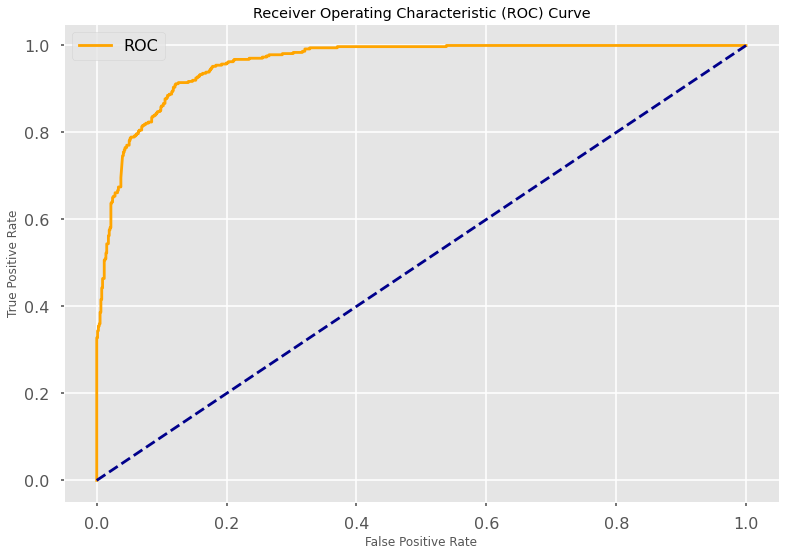

In [127]:
fpr, tpr, thresh = roc_curve(y_test, y_prob_lm)
plot_roc_curve(fpr, tpr)

In [128]:
roc_auc_score(y_test, y_prob_lm)

0.9592957264957265

In [129]:
#combining all scores into a dataframe
results = pd.DataFrame({'Navie_Bayes' : [accuracy_score(y_test, yhat),
f1_score(y_test, yhat),
precision_score(y_test, yhat),
recall_score(y_test, yhat),
roc_auc_score(y_test, y_prob)],
'Logistic_Regression' : [accuracy_score(y_test, yhat_log),
f1_score(y_test, yhat_log),
precision_score(y_test, yhat_log),
recall_score(y_test, yhat_log),
roc_auc_score(y_test, y_prob_lm)]
})
#renaming row indexs 
results.index = ['accuracy', 'f1', 'precision', 'recall', 'roc_auc']

Below are the results from each model. The Logistic Regression model outperformed the Naive Bayes model in every category. 

In [131]:
results

           Navie_Bayes  Logistic_Regression
accuracy      0.854545             0.896104
f1            0.743902             0.831461
precision     0.868327             0.878338
recall        0.650667             0.789333
roc_auc       0.949860             0.959296


---
### **Conclusions**

To answer the original question posed in this project, we were able to accurately predict which congressmen tweeted what roughly 90% of the time. The limitations of this project is mainly that the method we used was a "Bag of Words" method. Meaning that we did not look at the context of the words just at word count frequency. With more time I would like to implement a more in depth model that looks at the surrounding words and context along with the sentiment of the tweets. 